# Getting started

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import logging
import copy
import dill as dill
import pandas as pd
from pathlib import Path

from ipywidgets import widgets
from scipy.interpolate import interp1d
from matplotlib import ticker
from matplotlib.ticker import MaxNLocator

# CHANGE THIS TO BE A SUBREPO
import ompy as om

import myplots as myplots

In [3]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
rc('axes', labelsize="large")
rc('errorbar', capsize=2.) # Set error bar style

In [4]:
om.__full_version__

'0.9.1.dev0+29049e4'

In [5]:
# For reproducability we seed the random generator. 
# Note that by default several other classes in ompy, such as all
# classes with multinest calculations have a default seed, too
np.random.seed(1382398)

In [6]:
# get smaller files for the online version
plt.rcParams["figure.dpi"] = 70

## Loading raw data (particle - $\gamma$-ray coincidence matrix)
<a id='loading_data'></a>

The $^{164}\mathrm{Dy}$ data used below has been gathered from following experiment: Nyhus, H. T. *et al.* (2010). DOI: [10.1103/physrevc.81.024325](https://doi.org/10.1103/PhysRevC.81.024325)
and is reanalyzed in Renstrøm, T. *et al.* (2018). DOI: [10.1103/physrevc.98.054310](https://doi.org/10.1103/PhysRevC.98.054310)

**Select dataset**

Very similar notebooks are used for the *real* $^{164}\mathrm{Dy}$, and for those where we have reduced the count statistics. Therefore we need to set some variables here.

In [7]:
case = widgets.RadioButtons(options = ["164Dy: original", 
                                       "164Dy: reduced counts",
                                       "164Dy: synthetic"],
                            description='Choose case:',
                            index=2 # default selection
                            )
display(case)

RadioButtons(description='Choose case:', index=2, options=('164Dy: original', '164Dy: reduced counts', '164Dy:…

In [8]:
print(f"Selected case: {case}")
if case.index == 0:
    file_prefix = "164Dy"
    counts_multiplyer = 1 # no change
    Ex_max = 7700 # keV
    nld_limit_low = [0.6, 1.7]
    gsf_model_high_Efit = [4.5, 7]
    fndiscrete = 'ompy/example_data/discrete_levels_Dy164.txt'
    D0 = [6.8, 0.6]  # eV
elif case.index == 1:
    file_prefix = "164Dy_reduced"
    counts_multiplyer = 1/20 # reducing statistics
    Ex_max = 5900 # keV
    nld_limit_low = [0.6, 1.7]
    gsf_model_high_Efit = [4.5, 5.7]
    fndiscrete = 'ompy/example_data/discrete_levels_Dy164.txt'
    D0 = [6.8, 0.6]  # eV
elif case.index == 2:
    file_prefix = "164Dy_synthetic"
    counts_multiplyer = 1 # reducing statistics
    Ex_max = 7500 # keV
    nld_limit_low = [0.4, 1.8]
    gsf_model_high_Efit = [4.5, 7]
    fndiscrete = 'RAINIER_164Dy/levels_Dy164_synthetic.txt'
    ExEg_path = "RAINIER_164Dy/ExEg.m"
    D0 = [7.4, 0.6]  # eV
else:
    raise NotImplementedError(f"case: {case} is not implemented. Check spelling")

Selected case: RadioButtons(description='Choose case:', index=2, options=('164Dy: original', '164Dy: reduced counts', '164Dy: synthetic'), value='164Dy: synthetic')


In [9]:
# the `regernerate` flag ensures, that we don't load from disk; which might result in expected results
# if we have changed something in the input `raw` matrix.
regenerate_response = False
regenerate_ensemble = False
regenerate_normalizers = False

# number of ensemble members
N_members = 50

<IPython.core.display.Javascript object>


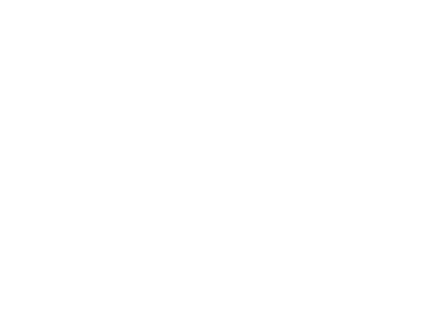

In [10]:
# Import raw matrix into instance of om.Matrix() and plot it
if case.index in [0,1]:
    raw = om.example_raw('Dy164')
    raw.plot(vmin=1)
elif case.index == 2:
    # there the "raw" matrix is still the unfolded matrix -- need to fold it below
    raw = om.Matrix(path=ExEg_path)
    raw.plot()

<IPython.core.display.Javascript object>


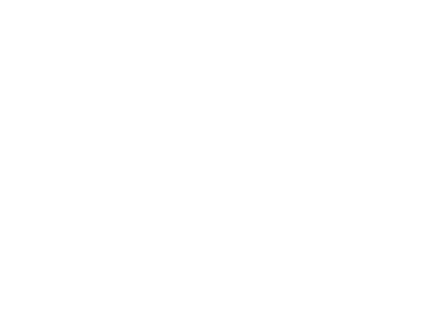

In [11]:
# Cut away unneccesary parts of the matrix 
# (-> shorter time to unfold & removed some remaining bg noise)
raw.cut_diagonal(E1=(800, 0), E2=(7500, 7300))
raw.cut('Ex', 0, 8400)
raw.plot(vmin=1);

## Unfolding

### Get a response matrix

In [12]:
logger = om.introspection.get_logger('response', 'INFO')
# Then do the same using OMpy functionality:
# You may need to adpot this to whereever you response matrixes are stored
folderpath = "ompy/OCL_response_functions/nai2012_for_opt13"

# Energy calibration of resulting response matrix:
Eg = raw.Eg

# Experimental relative FWHM at 1.33 MeV of resulting array
fwhm_abs = 90.44 # (90/1330 = 6.8%)

fname_response_save = Path(f'saved_run/response_{file_prefix}')
fname_response_save.mkdir(exist_ok=True, parents=True)
try:
    if regenerate_response:
        raise AssertionError("regenerate set to false; fall back to normalize")
    R_ompy_view = om.Matrix(path=fname_response_save / "R_ompy_view.m")
    R_ompy_unf = om.Matrix(path=fname_response_save / "R_ompy_unf.m")
    R_tab_view = pd.read_pickle(fname_response_save / "R_tab_view.pkl")
    R_tab_unf = pd.read_pickle(fname_response_save / "R_tab_unf.pkl")

except (OSError, FileNotFoundError, AssertionError) as e:
    response = om.Response(folderpath)
    R_ompy_view, R_tab_view = response.interpolate(Eg, fwhm_abs=fwhm_abs, return_table=True)
    # Magne recommends 1/10 of the actual resolution for unfolding purposes (see article)
    R_ompy_unf, R_tab_unf = response.interpolate(Eg, fwhm_abs=fwhm_abs/10, return_table=True)
    
    R_ompy_view.save(path=fname_response_save / "R_ompy_view.m")
    R_ompy_unf.save(path=fname_response_save / "R_ompy_unf.m")
    R_tab_view.to_pickle(fname_response_save / "R_tab_view.pkl")
    R_tab_unf.to_pickle(fname_response_save / "R_tab_unf.pkl")

For the CACTUS setup, there is an additional experimenal threshold, that is not taken into account in the original response matrix

In [13]:
fthreshold = interp1d([30., 80., 122., 183., 244., 294., 344., 562., 779., 1000.],
                      [0.0, 0.0, 0.0, 0.06, 0.44, 0.60, 0.87, 0.99, 1.00, 1.00],
                      fill_value="extrapolate")

def apply_detector_threshold(response, table, fthreshold):
    thres = fthreshold(response.Eg)
    response.values = response.values * thres
    # renormalize
    response.values = om.div0(response.values, response.values.sum(axis=1)[:, np.newaxis])
    table["eff_tot"] *= thres

apply_detector_threshold(R_ompy_unf, R_tab_unf, fthreshold)
apply_detector_threshold(R_ompy_view, R_tab_view, fthreshold)

<IPython.core.display.Javascript object>


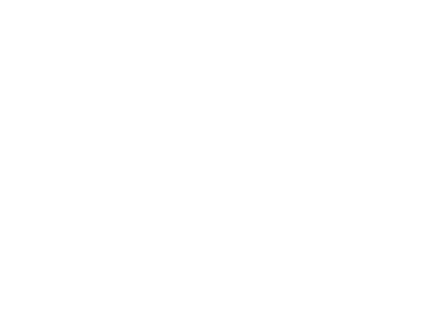

In [14]:
# for the synthetic data, we need to fold the unfolded (all-gen) spectrum
if case.index == 2:
    # fold
    raw = raw@R_ompy_view
    # rebin Ex to have similar binning as exp sepctrum
    raw.rebin("Ex", factor=3)
    raw.plot(vmin=1, vmax=1e3)

<IPython.core.display.Javascript object>


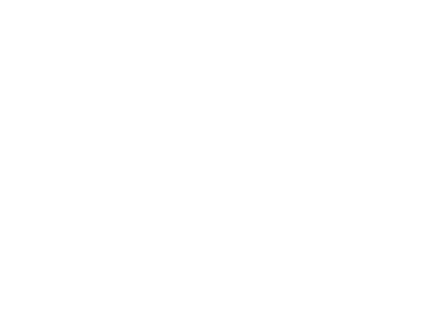

Text(0.5, 0, 'Measured $\\gamma$-ray energy $E_{\\gamma} [keV]$')

In [15]:
fig, ax = plt.subplots()
R_ompy_view.plot(ax=ax, title="Response matrix", vmin=5e-5, vmax=5e-1,
                 scale="log");
ax.set_ylabel(r"Incident $\gamma$-ray energy $E_{\gamma} [keV]$")
ax.set_xlabel(r"Measured $\gamma$-ray energy $E_{\gamma} [keV]$")

### Perform the unfolding & reduce statistics, if applicable

In [16]:
# arificially reduce statistics
raw_positive = raw.copy()
raw_positive *= counts_multiplyer

# round -- can't measure eg. 0.5 counts
if case.index != 2:
    raw_positive.values = np.around(raw_positive.values)

# We need to remove negative counts (unphysical) in the raw matrix before unfolding:
raw_positive.remove_negative()

<IPython.core.display.Javascript object>


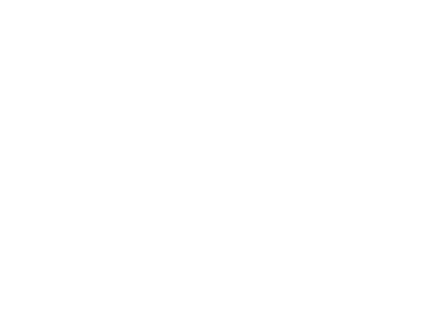

In [17]:
# You can decide to log information and set the logging level (info/debug)
logger = om.introspection.get_logger('unfolder', 'INFO')

# With compton subtraction and all tweaks
unfolder= om.Unfolder(response=R_ompy_unf)
unfolder.response_tab = R_tab_unf
# Magne suggests some "tweaks" for a better unfolding performance. Default is 1 for all.
unfolder.FWHM_tweak_multiplier = {"fe": 1., "se": 1.1,
                                     "de": 1.3, "511": 0.9}
unfolded = unfolder(raw_positive)
unfolded.plot();

In [18]:
### Generate the first generation matrix

<IPython.core.display.Javascript object>


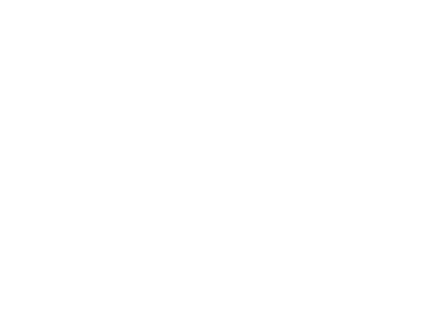

In [19]:
firstgen = om.FirstGeneration()
primary = firstgen(unfolded)
primary.plot();

## Propagating statistical uncertainties

In order to propagate the statistical uncertainties from the raw matrix, we use an ensemble based method. We start of my generating en enseble of *raw-like* matrixes. The raw counts are poisson distributed. If we had counted one another time, we would get slightly different results. 

More precisely, the counts of the matrix containing `prompt+bg` events and the background events `bg` are each poisson distributed, where we have `raw = (prompt+bg) - bg_ratio * bg`. The ratio `bg_ratio` is determined by the ratio of the time gate lengths taken to obtain the `prompt+bg` and `bg` spectra. If a `bg` spectrum is provided to the `Ensemble` class, it will calculate the raw spectrum according to the equaltion above. Otherwise, the provided `raw` spectrum itself is assumed to be poisson distributed.

For this experiment, we currently only have the `raw` matrix available, thus we propagate the error from there.

We take the number of counts $k_i$ in bin $i$ of the raw matrix $R$ as an estimate for the Poisson parameter ("the mean") $λ_i$ . Note that it is an unbiased estimator for $λ_i$, since $E(k) = λ$. To generate a member matrix $R_l$ of the MC ensemble, we replace the counts in each bin $i$ by a random draw from the distribution $\operatorname{Poisson}(k_i)$.

The class Ensemble() provides this feature. Its basic usage is:

In [20]:
logger = om.introspection.get_logger('ensemble', 'INFO')

# Tell the `Ensemble` class which raw spectrum, what kind of undolfer and first
# generations method to use.
# Note: This will have the same setting as above. We could for example have
# set the first generations method to use a different "valley_collection", or a
# differnt type of "multiplicity_estimation"
ensemble = om.Ensemble(raw=raw_positive,  path=f"saved_run/ensemble_{file_prefix}")
ensemble.unfolder = unfolder
ensemble.first_generation_method = firstgen
# Generates N perturbated members;
# the `regernerate` flag ensures, that we don't load from disk; which might result in expected results
# if we have changed something in the input `raw` matrix.
ensemble.generate(N_members, regenerate=regenerate_ensemble)

2020-03-26 14:24:09,266 - ompy.ensemble - INFO - Start normalization with 1 cpus
2020-03-26 14:24:09,366 - ompy.ensemble - INFO - Generating 0


2020-03-26 14:24:09,413 - ompy.ensemble - INFO - Generating 1
2020-03-26 14:24:09,443 - ompy.ensemble - INFO - Generating 2
2020-03-26 14:24:09,474 - ompy.ensemble - INFO - Generating 3
2020-03-26 14:24:09,504 - ompy.ensemble - INFO - Generating 4
2020-03-26 14:24:09,540 - ompy.ensemble - INFO - Generating 5
2020-03-26 14:24:09,571 - ompy.ensemble - INFO - Generating 6
2020-03-26 14:24:09,601 - ompy.ensemble - INFO - Generating 7
2020-03-26 14:24:09,635 - ompy.ensemble - INFO - Generating 8
2020-03-26 14:24:09,671 - ompy.ensemble - INFO - Generating 9
2020-03-26 14:24:09,697 - ompy.ensemble - INFO - Generating 10
2020-03-26 14:24:09,731 - ompy.ensemble - INFO - Generating 11
2020-03-26 14:24:09,757 - ompy.ensemble - INFO - Generating 12
2020-03-26 14:24:09,797 - ompy.ensemble - INFO - Generating 13
2020-03-26 14:24:09,825 - ompy.ensemble - INFO - Generating 14
2020-03-26 14:24:09,855 - ompy.ensemble - INFO - Generating 15
2020-03-26 14:24:09,891 - ompy.ensemble - INFO - Generating 16
2

The generated members are saved to disk and can be retrieved. Unfolded members can be retrieved as `ensemble.get_unfolded(i)`, for example. Their standard deviation is `ensemble.std_unfolded` for the unfolded matrixes, etc.

We can now plot the standard deviation of all ensemble members for the raw, unfolded and first generation spectrum 

In [21]:
# switch to inline due to problems with the backend on this machine
%matplotlib inline  
#calling it a second time may prevent some graphics errors
%matplotlib inline 

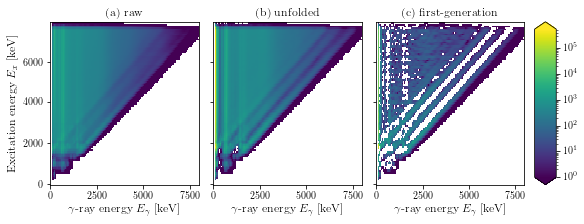

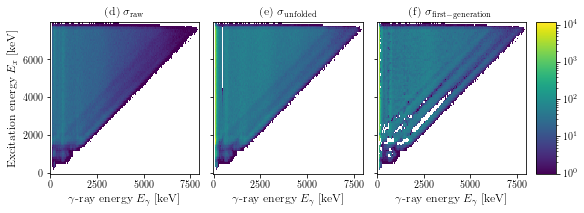

In [22]:
# plot of the ensemble (mean)
fig, ax = myplots.ensemble_plot(ensemble)
fig.set_size_inches((8, 3))

def add_to_labels(ax, axis, pre="", post=" [keV]"):
    if axis == "x":
        ax.set_xlabel(pre + ax.get_xlabel() + post)
    elif axis == "y":
        ax.set_ylabel(pre + ax.get_ylabel() + post)
    else:
        NotImplementedError("Only 'x' and 'y' are implemented.")

add_to_labels(ax[0], "y")
for ax_ in ax:
    locator = MaxNLocator(prune='both', nbins=5)
    ax_.yaxis.set_major_locator(locator)
    add_to_labels(ax_, "x")
    

fig.savefig(f"figs/ensemble_{file_prefix}.jpeg", dpi=300)

# plot of the ensemble std. dev.
fig, ax = ensemble.plot()
ax[0].set_title("(d) $\sigma_\mathrm{raw}$")
ax[1].set_title("(e) $\sigma_\mathrm{unfolded}$")
ax[2].set_title("(f) $\sigma_\mathrm{first-generation}$")
fig.suptitle("")

add_to_labels(ax[0], "y")
for ax_ in ax:
    locator = MaxNLocator(prune='both', nbins=5)
    ax_.yaxis.set_major_locator(locator)
    add_to_labels(ax_, "x")

fig.set_size_inches((8, 3))
fig.savefig(f"figs/ensemble2_{file_prefix}.jpeg", dpi=300)

In [23]:
# switch back for the analysis
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook 

## Extract Nuclear level density and gamma strength function

After matrix has been cut, unfolded and firstgen'd, perhaps ensembled, its nuclear level density (nld) and gamma strength function ($\gamma$SF) can be extracted using the `Extractor()` class.  

The method relies on the relation
 \begin{align}
	P(E_x, E_\gamma) \propto NLD(E_x - E_\gamma) \mathcal{T}(E_\gamma),\label{eq:Oslo_method_eq}
\end{align}
where $P(E_x, E_\gamma)$ is the first-generation spectrum normalized to unity for each $E_x$ bin.  
Furthermore, if we assume that the $\gamma$ decay at high $E_x$ is dominated by dipole radiation the transmission coefficient $\mathcal{T}$ is related to the dipole $\gamma$-ray strength function $f(E_\gamma)$ by the relation
\begin{align}
    \mathcal{T}(E_\gamma) = 2\pi E_\gamma^3 f(E_\gamma).\label{eq:gammaSF}
\end{align} 

If you have reasons to assume a different multipose decomposition, you may of course calculate the transmission coefficient $\mathcal{T}$ from the $\gamma$-ray strength function produced here and apply the decomposition you prefer.

When extracting NLD and GSF from an ensemble, a trapezoidal cutout must be performed on each ensemble member. This is achieved by `Action()` which allows for delayed function calls on matrices and vectors. This way we don't cut the raw matrix at `Ex_min`, but this will only happen before the extraction.

<IPython.core.display.Javascript object>


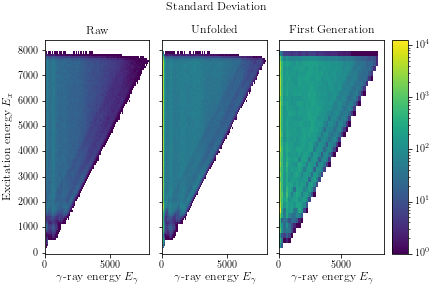

In [24]:
trapezoid_cut = om.Action('matrix')
trapezoid_cut.trapezoid(Ex_min=4400, Ex_max=Ex_max, Eg_min=1300, 
                        Eg_max=Ex_max+200, inplace=True)
extractor = om.Extractor(path=f"saved_run/extraction_ensemble_{file_prefix}")
extractor.trapezoid = trapezoid_cut
# Running the lines below directy, would most probably 
# result in a error like
# The AssertionError: Ex and Eg must have the same step size
#
# Why? The extraction assumes that Ex and Eg have the same binning. Thus we
# need to rebin the ensemble. This works will work inplace. 
# Note: As always, be careful will mid-bin vs lower bin calibration.
# E_rebinned = ensemble.get_firstgen(0).Ex
# 
E_rebinned = np.arange(100., 8500, 200)
ensemble.rebin(E_rebinned, member="firstgen")
ensemble.plot();

Now we can extract the NLD and $\gamma SF$ for $N$ of the samples of the ensemble.

Note: 
The old software extended the decomposition beyond the `Ex=Eg` line by a resolution `dE`. This is now optional and we changed the default to not do this any longer, but rather assume that the rebinning above has been performed with a binsize of approx. the FWHM of the bin with the worst resolution (usually `(Ex_max, Eg_max)`).

In [25]:
extractor.extract_from(ensemble, regenerate=regenerate_ensemble)

The resulting `nld` and `gsf` are saved to disk and exposed as `extractor.nld` and `extractor.gsf`

**Create another comparison Figure:**  
    Normalized 1Gen spectrum from data, vs. the fitted product of NLD and $\gamma$SF

<IPython.core.display.Javascript object>


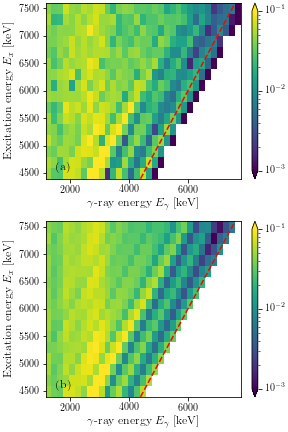

In [26]:
mat = ensemble.get_firstgen(0).copy()
std = ensemble.std_firstgen.copy()
trapezoid_cut.act_on(mat)
trapezoid_cut.act_on(std)
_, _, product = extractor.decompose(mat, std, product=True)

fig, ax = plt.subplots(2,1, constrained_layout=True)
fig.set_size_inches(4, 6)
om.normalize_rows(mat.values) 
mat.plot(ax=ax[0], scale="log", vmin=1e-3, vmax=1e-1, title="")
product.plot(ax=ax[1], scale="log", vmin=1e-3, vmax=1e-1, title="")

x = np.linspace(*ax[0].get_ylim())
ax[0].plot(x, x, "r--", label="E_x = E_g")
ax[1].plot(x, x, "r--", label="E_x = E_g")

ax[0].set_xlabel(r"$\gamma$-ray energy $E_\gamma$ [keV]")
ax[0].set_ylabel(r"Excitation energy $E_x$ [keV]")
ax[1].set_xlabel(r"$\gamma$-ray energy $E_\gamma$ [keV]")
ax[1].set_ylabel(r"Excitation energy $E_x$ [keV]")

ax[0].text(0.05, 0.05, r"(a)",
           fontsize=plt.rcParams["axes.labelsize"], 
           transform = ax[0].transAxes)

ax[1].text(0.05, 0.05, r"(b)",
           fontsize=plt.rcParams["axes.labelsize"], 
           transform = ax[1].transAxes)

fig.savefig(f"figs/fg_vs_product_{file_prefix}.pdf", dpi=300)

### Plotting the results before normalization

<IPython.core.display.Javascript object>


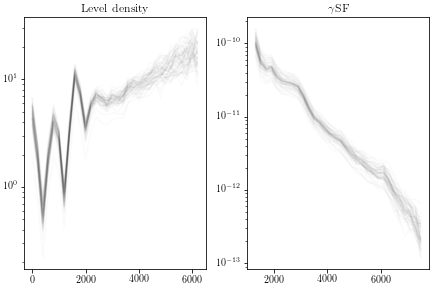

(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f984b29b1d0>,
       dtype=object))

In [27]:
extractor.plot(plot_mean=False)

Or maybe you are more used to displaying the results with std. deviations?

**Note**: This may be erroneous, as the nld and gsf are not normalized yet!  
Thus, in principal, we might evaluate std. devs. of the *same solution* with different  
transformations. Before we normalize, we don't know. And they have the same $\chi^2$.  
That was the reason for the *trouble* with normalization.



<IPython.core.display.Javascript object>


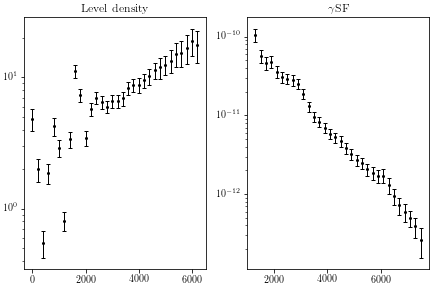

(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9848075e10>,
       dtype=object))

In [28]:
extractor.plot(plot_mean=True)

In [29]:
# let's remove the nan-valued elements (unconstrained elements) for the further analysis
extractor_org = copy.deepcopy(extractor)
for nld in extractor.nld:
    nld.cut_nan()
for gsf in extractor.gsf:
    gsf.cut_nan()

# the "mean" nld at this stage; we'll use it later, but it's not a good estimate at this
# stage (see article)
nld_mean = extractor.ensemble_nld()

Plot for the article (before normalization):  
Comparing the initial guess to the fitted solution

<IPython.core.display.Javascript object>


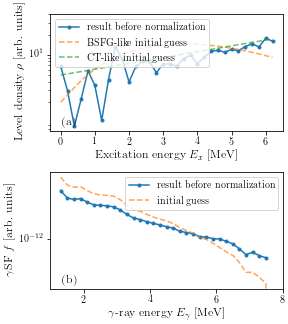

In [30]:
fig, ax = plt.subplots(2, 1, constrained_layout=True)
fig.set_size_inches(4, 4.5)
nld, gsf = extractor.nld[0].copy(), extractor.gsf[0].copy()

nld.to_MeV()
nld.plot(ax=ax[0], scale="log", label="result before normalization")
# ax[0].set_title("(a) Level density")
ax[0].set_ylim(ax[0].get_ylim()[0], ax[0].get_ylim()[1]*2)
ax[0].set_ylabel(r"Level density $\rho$ [arb. units]")

gsf.to_MeV()
gsf.plot(ax=ax[1], scale="log", label="result before normalization")
# ax[1].set_title(r"(b) $\gamma$SF")
ax[1].set_ylabel(r"$\gamma$SF $f$ [arb. units]")

# plot initial guess
x0 = extractor.guess_initial_values(E_nld=extractor.nld[0].E, matrix=product, method="BSFG-like")
T0 = x0[:product.Eg.size]
nld0 = x0[product.Eg.size:]
nld0 = om.Vector(values=nld0, E=extractor.nld[0].E/1000)
nld0.transform(const=10, inplace=False).plot(ax=ax[0], linestyle="--", markersize=0, alpha=0.7,
                                             label="BSFG-like initial guess")

x0 = extractor.guess_initial_values(E_nld=extractor.nld[0].E, matrix=product, method="CT-like")
T0 = x0[:product.Eg.size]
nld0 = x0[product.Eg.size:]
nld0 = om.Vector(values=nld0, E=extractor.nld[0].E/1000)
nld0.transform(const=5, alpha=0.2, inplace=False).plot(ax=ax[0], linestyle="--", markersize=0, alpha=0.7,
                                                       label="CT-like initial guess")

gsf0 = om.Vector(values=T0, E=extractor_org.gsf[0].E/1000)
gsf0.values /= gsf0.E**3
gsf0.transform(const=10e-10, inplace=False).plot(ax=ax[1], linestyle="--", markersize=0, alpha=0.7, 
                                              label="initial guess")    

for ax_ in ax:
    ax_.set_yscale("log")
    ax_.yaxis.set_major_locator(ticker.LogLocator(numticks=2))

ax[0].legend(loc="upper left")
ax[1].legend(loc="upper right")
    
ax[0].set_xlabel(r"Excitation energy $E_x$ [MeV]")
ax[1].set_xlabel(r"$\gamma$-ray energy $E_\gamma$ [MeV]")

ax[0].text(0.05, 0.05, r"(a)",
           fontsize=plt.rcParams["axes.labelsize"], 
           transform = ax[0].transAxes)

ax[1].text(0.05, 0.05, r"(b)",
           fontsize=plt.rcParams["axes.labelsize"], 
           transform = ax[1].transAxes)   
    
fig.savefig(f"figs/nld_gsf_raw_{file_prefix}.pdf", dpi=300)

## Normalization

Does it still look *strange*? probably because you are only used to see the normalized results.

### 1) Manual normalization

<IPython.core.display.Javascript object>


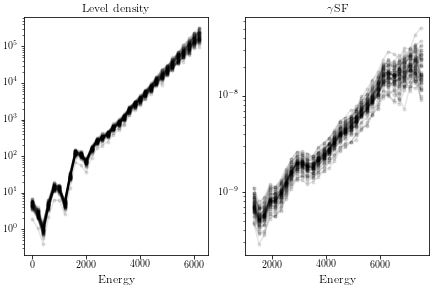

In [31]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plot_transformed(alpha, A=1, B=1):
    fig, ax = plt.subplots(1, 2, constrained_layout=True)
    for nld, gsf in zip(extractor.nld, extractor.gsf):
        nld.transform(const=A, alpha=alpha, inplace=False).plot(ax=ax[0], scale="log", color='k', alpha=1/10)
        gsf.transform(const=B, alpha=alpha, inplace=False).plot(ax=ax[1], scale="log", color='k', alpha=1/10)
    ax[0].set_title("Level density")
    ax[1].set_title(r"$\gamma$SF")

plot_transformed(alpha=0.0015)

### 2) Normalization through external data for one (nld, gsf) set

The normalization ensures that we find the *physical* solution, so we remove the degeneracy that is in principal inherent to decomposition of NLD and $\gamma$SF:
\begin{align}
NLD' = NLD(E_x) * A exp(\alpha E_x) \\
\gamma SF' = \gamma SF(E_\gamma) * B exp(\alpha E_\gamma)
\end{align}
Note: This is the transformation eq (3), Schiller2000.

As external data for the normalization we commonly use:
1. the discrete leves, binned with the resolution of our data (and potentially also smoothed)
2. The NLD at Sn, derived from D0 and a spin distribution
3. The average total radiative width $\Gamma_\gamma$.

#### 1. Sequentially:
Traditionally we have choosen a sequential normalization, where the NLD is normalized first to receive a set $\alpha$. Then we obtain the scaling parameter $B$ of the $\gamma$SF from a normalization to the experimental $\Gamma_\gamma$.

We go though this herem becaue it can be instructive to see. Also, we need to set the parameters, anyhow.

##### nld normalization  
Let's first normalize the mean nld from the extractor.

The normalization will take some time (≲ 30 seconds). The essential output of multinest is saved to disk, and some output is redirected to disk.

In [32]:
normlog = om.introspection.get_logger('normalizer_nld', 'INFO')
normpath = f'saved_run/normalizer_{file_prefix}'
nldnorm = om.NormalizerNLD(nld=nld_mean, discrete=fndiscrete, path=normpath, 
                           regenerate=regenerate_normalizers)

In [33]:
norm_pars = om.NormalizationParameters(name="164Dy")
norm_pars.D0 = D0
norm_pars.Sn = [7.658, 0.001] # MeV

norm_pars.spincutModel = 'Disc_and_EB05'  # see eg. Guttormsen et al., 2017, PRC 96, 024313
# Note: The parameters below gave been adjusted to match the values in Renstrom et al.; 
# equvivalent of using their reduction factor \eta = np.sqrt(0.9)
norm_pars.spincutPars = {"mass":164, "NLDa":22.2,
                         "Eshift":0.31,
                         "Sn": norm_pars.Sn[0], "sigma2_disc":[1.5, 3.6]}
    
norm_pars.Jtarget = 5/2 # A-1 nucleus

nldnorm.bounds["A"] = [0.001, 100]
nldnorm.bounds["alpha"] = [1, 2]

nldnorm.limit_low = nld_limit_low
# nldnorm.limit_high = [3, 6.5]
# nldnorm2.normalize(limit_high = [2.2, 4.6])
# nldnorm.limit_high = [3, 4.6]
nldnorm.limit_high = [3, 6.5]

nldnorm.norm_pars = norm_pars

In [34]:
nldnorm.normalize()

2020-03-26 14:24:22,427 - ompy.normalizer_nld - INFO - Try loading from saved_run/normalizer_164Dy_synthetic/NormalizerNLD.pkl
2020-03-26 14:24:22,431 - ompy.normalizer_nld - INFO - Loaded


In [35]:
# for comparison with the Restrom article
nldSn_from_D0 = nldnorm.nldSn_from_D0(**norm_pars.asdict())
print(f"nld(Sn) from D0: {nldSn_from_D0[1]:.2e} MeV^-1")

nld(Sn) from D0: 2.16e+06 MeV^-1


<IPython.core.display.Javascript object>


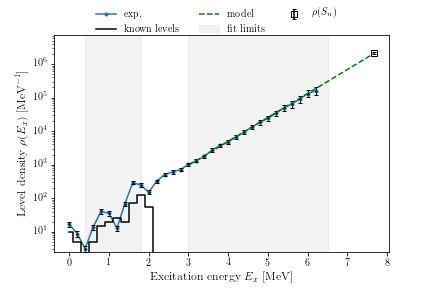

In [36]:
nldnorm.plot();


Observe that you might get *strange* results, i.e. unexpected results here, as you use the (potentially erroneous determinated) uncertainties of `nld_mean` in the normalzation, instead of the proper normalization below.

##### $\gamma$-SF Normalization

In [37]:
normlog = om.introspection.get_logger('normalizer_gsf', 'INFO')
gsfnorm = om.NormalizerGSF(normalizer_nld=nldnorm, gsf=extractor.gsf[0],
                           path=normpath, regenerate=True)

# to be use for gsf normalization
norm_pars.Gg = [113., 13.]  #meV

gsfnorm.norm_pars = norm_pars
gsfnorm.model_low.Efit=[1.9, 2.5]
gsfnorm.model_high.Efit = gsf_model_high_Efit

In [38]:
gsfnorm.normalize()

2020-03-26 14:24:22,779 - ompy.normalizer_gsf - INFO - Normalizing #0
2020-03-26 14:24:22,787 - ompy.normalizer_gsf - INFO - Saving to saved_run/normalizer_164Dy_synthetic/NormalizerGSF.pkl


<IPython.core.display.Javascript object>


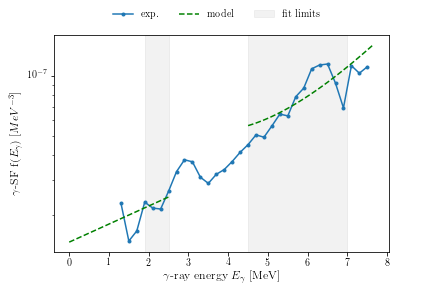

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f983cfcadd0>)

In [39]:
gsfnorm.plot()

It's often instructive to plot the extrapolation of the $\gamma$SF; with the interactive code below, we can check the influence of choosing different fit regions. The latest choice is kept for the simultaneous normalization below.

2020-03-26 14:24:22,956 - ompy.normalizer_gsf - INFO - Normalizing #0
2020-03-26 14:24:22,962 - ompy.normalizer_gsf - INFO - Saving to saved_run/normalizer_164Dy_synthetic/NormalizerGSF.pkl


<IPython.core.display.Javascript object>


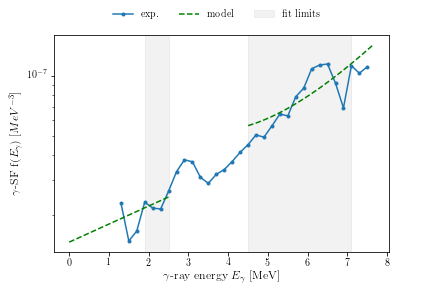

interactive(children=(SelectionRangeSlider(description='Elow', index=(3, 6), options=((1.3, 1.3), (1.5, 1.5), …

In [40]:
gsfnorm.plot_interactive()

#### 2. Simultaneous:
We now propose to normalize the NLD and $\gamma$SF simultaneously instead. This way, we are guaranteed to get matching combinations of the normalization parameters $A$, $B$ and $\alpha$ for a given ensemble member.

In [41]:
normlog = om.introspection.get_logger('normalizer_simultan', 'INFO')
simnorm = om.NormalizerSimultan(normalizer_nld=nldnorm, normalizer_gsf=gsfnorm,
                                path=normpath, regenerate=regenerate_normalizers)
simnorm.multinest_kwargs["n_live_points"] = 400

simnorm.path = normpath


In [42]:
simnorm.normalize(gsf=extractor.gsf[0], nld=extractor.nld[0])

2020-03-26 14:24:23,275 - ompy.normalizer_simultan - INFO - Try loading from saved_run/normalizer_164Dy_synthetic/NormalizerSimultan.pkl
2020-03-26 14:24:23,280 - ompy.normalizer_simultan - INFO - Loaded


<IPython.core.display.Javascript object>


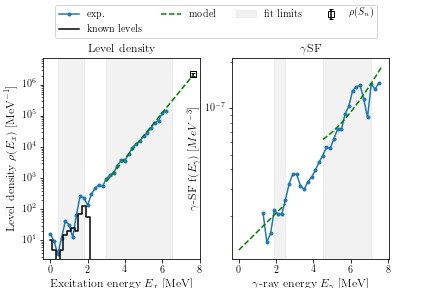

In [43]:
simnorm.plot();


### 3. Normalization the whole ensemble
We have now also developed the toolset to normalize each member of the extractor ensemble separatly. This should provide a statistically more sound and robust normalization. 

Why so? As the $\chi^2$ error function is degenerate, a good minimizer should return sets of (nld, gsf) that need to be normalized with different coefficients $A$, $B$ and $\alpha$. Thus we should normalize each of these sets independently, and build up an uncertainty band only after the normalization. (Instead of the *traditional* approach of normalizing the mean of the sets)

Again, you decide whether you normalize sequencially, or, as we **recommend**, to normalize simultaneously.

Note that this will this may take several minutes!

#### Sequential normalization

In [44]:
# normlog = om.introspection.get_logger('ensembleNormalizer', 'INFO')
# ensemblenorm_seq = om.EnsembleNormalizer(extractor=extractor, normalizer_nld=nldnorm,
#                                      normalizer_gsf=gsfnorm)
# ensemblenorm_seq.normalize()

In [45]:
# ensemblenorm_seq.plot();

#### Simultaneous normalization

In [46]:
normlog = om.introspection.get_logger('ensembleNormalizer', 'INFO')
ensemblenorm_sim = om.EnsembleNormalizer(extractor=extractor, normalizer_simultan=simnorm,
                                         path=normpath, regenerate=regenerate_normalizers)
ensemblenorm_sim.normalizer_simultan.multinest_kwargs["n_live_points"] = 400

ensemblenorm_sim.path = normpath


In [47]:
ensemblenorm_sim.normalize()

2020-03-26 14:24:23,554 - ompy.ensembleNormalizer - INFO - Try loading from saved_run/normalizer_164Dy_synthetic/EnsembleNormalizer.pkl
2020-03-26 14:24:23,573 - ompy.ensembleNormalizer - INFO - Loaded


<IPython.core.display.Javascript object>


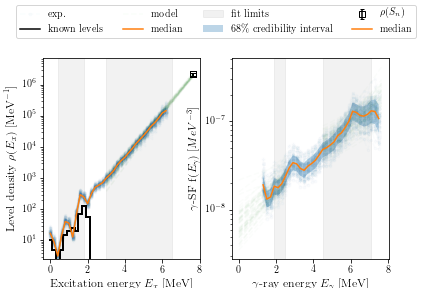

In [48]:
ensemblenorm_sim.plot(n_plot=60);

#### Compare to oslo-method-software
For reference to the dataset, see [here](#loading_data)

In [49]:
if case.index in [0, 1]:
    fig, ax = plt.subplots(1, 2, constrained_layout=True)
    _, _, stats = ensemblenorm_sim.plot(ax, n_plot=1, add_figlegend=False,
                         plot_model_stats=True,
                         random_state=np.random.default_rng(6577),
                                       return_stats=True)


    colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
    color = colors[7]

    # Load and add published, normalized data:
    # format:
    # Eg(MeV)	 nld(MeV^-1)	 err_rsg(MeV^-1)	 err_tot(MeV^-1)
    label=r"Renstr{\o}m $\textit{et\,\,al.}$"
    nld_published = np.loadtxt("misc_data/nld_164Dy_3He_3He_164Dy.txt", skiprows=6)
    def plt_err(ax, arr, yerr="total", fmt="^", color=color,
                markerfacecolor='none', **kwargs):
        if yerr == "total":
            yerr = arr[:, 3]
        elif yerr == "statistical":
            yerr = arr[:, 2]
        else:
            raise NotImplementedError()
        ax.errorbar(arr[:, 0], arr[:, 1], yerr=yerr,
                       fmt=fmt, color=color, markerfacecolor=markerfacecolor,
                       **kwargs)

    plt_err(ax[0], nld_published, yerr="statistical", label=label)
    plt_err(ax[0], nld_published, yerr="total", label=None, capsize=0, alpha=0.5)

    # Load and add published, normalized data:
    # format:
    # Eg(MeV)	 f(MeV^-3)	 err_rsg(MeV^-3)	 err_tot(MeV^-3)
    gsf_published = np.loadtxt("misc_data/gsf_164Dy_3He_3He_164Dy.txt")
    plt_err(ax[1], gsf_published, yerr="statistical")
    plt_err(ax[1], gsf_published, yerr="total", capsize=0, alpha=0.5)

    for axis in ax:
        for l in axis.lines:
            if l._label in ["exp.", "_exp."]:
                l._markersize=3
            if l._label in ["exp."]: # rename
                l._label="sample"
            if l._label in ["median"]: # rename
                l._label="results"

    # shuffel labels
    handles, labels = ax[0].get_legend_handles_labels()
    
    new_indexes = [3, 6, 0, 4, 7, 5, 1, 8, 9]
    handles, labels = np.array(handles), np.array(labels)
    handles, labels = handles[new_indexes], labels[new_indexes]
    handles[0] = (handles[1], handles[0]),
    handles[1] = None
    handles[3] = (handles[4], handles[3]),
    handles[4] = None
    
    ax[0].legend(handles, labels, loc="best")

    ax[0].text(0.9, 0.05, r"(a)",
               fontsize=plt.rcParams["axes.labelsize"], 
               transform = ax[0].transAxes)

    ax[1].text(0.9, 0.05, r"(b)",
               fontsize=plt.rcParams["axes.labelsize"], 
               transform = ax[1].transAxes)  

    fig.set_size_inches((8, 4))
    # fig.tight_layout()
    fig.savefig(f"figs/normalized_{file_prefix}.pdf", dpi=300)

# try comparison in one figure

# CHANGE THIS ONE HERE!!!

In [50]:
try:
    file_prefix_ = "164Dy"
    fname_ensemblenorm_sim = f'ensemblenorm_sim_{file_prefix_}.pkl'
    with open(fname_ensemblenorm_sim, 'rb') as fobj:
        ensemblenorm_sim_org = dill.load(fobj)

    file_prefix_ = "164Dy_reduced"
    fname_ensemblenorm_sim = f'ensemblenorm_sim_{file_prefix_}.pkl'
    with open(fname_ensemblenorm_sim, 'rb') as fobj:
        ensemblenorm_sim_reduced = dill.load(fobj)
    loaded_files = True
except FileNotFoundError:
    print("could not find files")
    loaded_files = False
    pass

could not find files


In [51]:
if loaded_files:
    fig, ax = plt.subplots(1, 2, constrained_layout=True)
    _, _, stats_org = ensemblenorm_sim_org.plot(ax, n_plot=1, add_figlegend=False,
                         plot_model_stats=True,
                         random_state=np.random.default_rng(12345669),
                                       return_stats=True)

    # plot reduced nld_ on diff. scale
    ax0_twin = ax[0].twinx()
    ax1_twin = ax[1].twinx()
    _, _, stats_sim = ensemblenorm_sim_reduced.plot([ax0_twin, ax1_twin], n_plot=1, add_figlegend=False,
                         plot_model_stats=True,
                         random_state=np.random.default_rng(12345),
                                       return_stats=True)

    ax[1].set_ylim(2e-9, None)
    scaler = 5
    ax0_twin.set_ylim(np.array(ax[0].get_ylim())*scaler)
    ax1_twin.set_ylim(np.array(ax[1].get_ylim())*scaler)

    # remove additional labels
    for tax in [ax0_twin, ax1_twin]:
        tax.tick_params(axis='y', which='both', right=False, labelright=False)
        tax.set_ylabel(None)
        tax.patches = []  # remove (additional) "fit region" patch

    for axis in ax:
        axis.set_xlim(0, None)
        for l in axis.lines:
            if l._label in ["exp.", "_exp."]:
                l._markersize=3
            if l._label in ["exp."]: # rename
                l._label="sample"
            if l._label in ["median"]: # rename
                l._label="results"

    handles, labels = ax[0].get_legend_handles_labels()

    new_indexes = [3, 6, 0, 4, 7, 5, 1, 8]
    handles, labels = np.array(handles), np.array(labels)
    handles, labels = handles[new_indexes], labels[new_indexes]
    handles[0] = (handles[1], handles[0]),
    handles[1] = None
    handles[3] = (handles[4], handles[3]),
    handles[4] = None

    ax[0].legend(handles, labels, loc="best")

    ax[0].text(0.7, 0.5, f"x 1/{scaler}",
               fontsize=plt.rcParams["axes.labelsize"], 
               transform = ax[0].transAxes)
    ax[1].text(0.7, 0.35, f"x 1/{scaler}",
               fontsize=plt.rcParams["axes.labelsize"], 
               transform = ax[1].transAxes)

    ax[0].text(0.9, 0.05, r"(a)",
               fontsize=plt.rcParams["axes.labelsize"], 
               transform = ax[0].transAxes)

    ax[1].text(0.9, 0.05, r"(b)",
               fontsize=plt.rcParams["axes.labelsize"], 
               transform = ax[1].transAxes)  

    fig.set_size_inches((8, 4))
    fig.tight_layout()
    fig.savefig(f"figs/normalized_comparison.pdf", dpi=300)

# Synthetic data vs RAINIER input

<IPython.core.display.Javascript object>


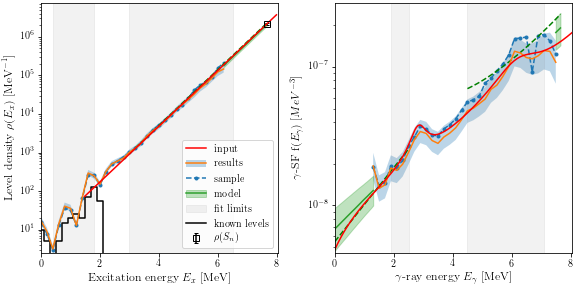

In [52]:
def plot_compare_RAINIER(normalizer, 
                         fname="compare_to_RAINIER.pdf"):
    fig, ax = plt.subplots(1, 2, constrained_layout=True)
    normalizer.plot(ax, n_plot=1, add_figlegend=False,
                          plot_model_stats=True, 
                          random_state=np.random.default_rng(123456))

    # load 'input' NLD and gsf
    # note that for the nld we should take the output from RAINIER (actual created level scheme)
    # here we load the continuum bins
    # format: Energy, levels_created [this bin], levels_model [MeV^-1], levels_model_from_tot [MeV^-1]
    nld_input = np.loadtxt("RAINIER_164Dy/NLDcont.dat")

    # # format: E, fE1+fM1, fE1, fM1
    gsf_input = np.loadtxt("RAINIER_164Dy/gsf.txt")
    # Gg from RAINIER in 153 meV -> scale gsf to get same Gg as here
    gsf_input[:, 1] *= norm_pars.Gg[0] / 153


    ax[0].plot(nld_input[:,0], nld_input[:,2], "r", label="input")
    ax[1].plot(gsf_input[:,0], gsf_input[:,1], "r")
    
    
    # remove additional labels
    #for tax in [ax0_twin, ax1_twin]:
    #    tax.tick_params(axis='y', which='both', right=False, labelright=False)
    #    tax.set_ylabel(None)
    #    tax.patches = []  # remove (additional) "fit region" patch

    for axis in ax:
        axis.set_xlim(0, None)
        for l in axis.lines:
            if l._label in ["exp.", "_exp."]:
                l._markersize=3
            if l._label in ["exp."]: # rename
                l._label="sample"
            if l._label in ["median"]: # rename
                l._label="results"

    handles, labels = ax[0].get_legend_handles_labels()

    new_indexes = [5, 3, 7, 0, 4, 8, 6, 1, 9]
    handles, labels = np.array(handles), np.array(labels)
    handles, labels = handles[new_indexes], labels[new_indexes]
    handles[1] = (handles[2], handles[1]),
    handles[2] = None
    handles[4] = (handles[5], handles[4]),
    handles[5] = None
    
    ax[0].legend(handles, labels, loc="best")

    fig.set_size_inches((8, 4))
    fig.savefig("figs/"+fname)
if case.index==2:
    plot_compare_RAINIER(ensemblenorm_sim, fname="compare_to_RAINIER.pdf")